# Машинное обучение при обработке текстов

Доступен датасет отзывов в интернет-магазине по критерию "токсичности" отзыва. Необходимо построить модель для классификации отзывов. Целевая метрика - f1-мера. Качество по метрике - не менее 0.75.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from tqdm import notebook

In [2]:
from catboost import CatBoostClassifier

In [43]:
conda install -c anaconda mkl

Solving environment: done

## Package Plan ##

  environment location: /Users/peterefimov/opt/anaconda3

  added / updated specs:
    - mkl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.5                |           py37_0         3.0 MB  anaconda
    mkl-2019.4                 |              233       155.2 MB  anaconda
    ------------------------------------------------------------
                                           Total:       158.2 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.5-py37hc8dfbb8~ --> anaconda::conda-4.8.5-py37_0
  mkl                                             pkgs/main --> anaconda



mkl-2019.4           | 155.2 MB  | ##################################### | 100% 
conda-4.8.5          | 3.0 MB    | ##################################### | 100% 
Preparing transaction: done
V

In [44]:
conda install -c pytorch pytorch torchvision

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: | 
  - anaconda/osx-64::conda-4.8.5-py37_0
  - defaults/osx-64::conda-4.8.5-py37done

## Package Plan ##

  environment location: /Users/peterefimov/opt/anaconda3

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ninja-1.9.0                |   py37h04f5b5a_0          90 KB
    pytorch-1.6.0              |          py3.7_0        54.5 MB  pytorch
    torchvision-0.7.0          |         py37_cpu         5.8 MB  pytorch
    ------------------------------------------------------------
                                           Total:        60.4 MB

The following NEW packages will be INSTALLED:

  ninja              pkgs/ma

In [48]:
conda install -c conda-forge transformers

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/peterefimov/opt/anaconda3

  added / updated specs:
    - transformers


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boto3-1.15.2               |     pyh9f0ad1d_0          69 KB  conda-forge
    botocore-1.18.2            |     pyh9f0ad1d_0         4.1 MB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    jmespath-0.10.0            |     pyh9f0ad1d_0          21 KB  conda-forge
    regex-2020.7.14            |   py37h60d8a13_0         338 KB  conda-forge
    s3transfer-0.3.3           |   py37hc8dfbb8_1          90 KB  conda-forge
    sacremoses-0.0.43          |     pyh9f0a

In [49]:
import torch
import transformers

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/peterefimov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/peterefimov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/peterefimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Загружаем данные

In [4]:
data = pd.read_csv('toxic_comments.csv')
# data = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
def data_information_printer(data):
    """Функция принимает на вход датасет и выводит основную информацию о нём"""
    display(data.head(10))
    print('-------- Информация о признаках --------')
    display(data.info())
    print('-------- Описание числовых признаков --------')
    display(data.describe())
    print('-------- Информация о пропусках --------')
    display(data.isna().sum())
    print('-------- Информация о дубликатах --------')
    display(data.duplicated().sum())

In [6]:
data_information_printer(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


-------- Информация о признаках --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

-------- Описание числовых признаков --------


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


-------- Информация о пропусках --------


text     0
toxic    0
dtype: int64

-------- Информация о дубликатах --------


0

Данные загружены, пропусков или дубликатов нет, замена типов данных на текущем этапе не требуется. 

## Лемматизация

Лемматизацию будем проводить в библиотеке NLTK, как более быстродейственной. 

In [7]:
# Для оценки работоспособности лемматизатора сделаем небольшой срез из общего датасета
data_short = data.sample(2000)

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
def get_wordnet_pos(word):
    """Функция принимает строку и подбирает POS-теги к словам. Возвращает теги"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def lem_func(text):
    """Функция принимает строку и лемматизирует её. Внутри функции ссылка на функцию для 
    получения тегов слов. Возвращает лемматизированную строку"""
    word_list = nltk.word_tokenize(text)
    lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(lemma)

In [13]:
%%time
data_short['lem_text'] = data_short['text'].apply(lem_func)

CPU times: user 19.5 s, sys: 2.16 s, total: 21.6 s
Wall time: 21.8 s


In [12]:
data_short.head()

,text,toxic
133177,Thanks for saying so! Would that it were done;...,0
27572,to poor and uncultivated Boing! said Zebedee \...,0
147302,"""\n\n Please stop your disruptive editing. If ...",0
121266,It doesn't matter if YOU think the information...,0
84214,Blocked and talkpage access revoked.,0


Таким образом, оценили работоспособность предложенного варианта лемматизации и оценили время работы. Лемматизация всего датасета по пропорции должна занять около получаса.

In [12]:
# %%time
# data['lem_text'] = data['text'].apply(lem_func)

CPU times: user 24min 39s, sys: 2min 39s, total: 27min 19s
Wall time: 27min 21s


Датасет лемматизирован. Обработка заняла около получаса, как и предполагалось. Так как в дальнейшем при работе несколько раз умирал Кернел, перезагрузим лемматизированный датасет.
Очистим текст от незначащих символов.

In [15]:
data = pd.read_csv('lemmatized_dataset.csv')
data.head()

,Unnamed: 0,text,toxic,lem_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D'aww ! He match this background colour I 'm s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"Hey man , I 'm really not try to edit war . It..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,`` More I ca n't make any real suggestion on i...
4,4,"You, sir, are my hero. Any chance you remember...",0,"You , sir , be my hero . Any chance you rememb..."


In [16]:
def clear_text_eng(text):
    """Функция приниает текст и удаляет из него все символы, кроме английских букв"""
    new_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cleared_text = ' '.join(new_text.split())
    return cleared_text

In [17]:
%%time
clear_data = data.copy()
clear_data.drop('text', axis = 1, inplace = True)

CPU times: user 19.3 ms, sys: 4.17 ms, total: 23.5 ms
Wall time: 23.1 ms


In [18]:
clear_data['lem_text'] = clear_data['lem_text'].apply(clear_text_eng)

In [19]:
clear_data.head(3)

,Unnamed: 0,toxic,lem_text
0,0,0,Explanation Why the edits make under my userna...
1,1,0,D aww He match this background colour I m seem...
2,2,0,Hey man I m really not try to edit war It s ju...


Данные очищены от незначащих символов. Теперь разделим данные на обучающую и тестовую выборки.

In [20]:
train, test = train_test_split(clear_data, test_size = 0.2, random_state = 13)

x_train = train.drop('toxic', axis = 1)
y_train = train['toxic']
x_test = test.drop('toxic', axis = 1)
y_test = test['toxic']

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((127656, 2), (127656,), (31915, 2), (31915,))

## Балансировка классов
Оценим баланс классов.

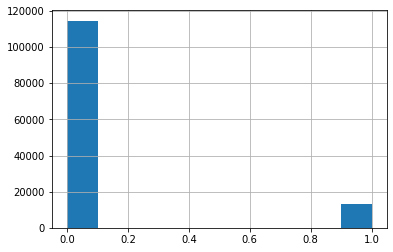

In [21]:
train['toxic'].hist()
plt.show()

Данные несбалансированны, оценим степень дисбаланса

In [22]:
toxic_quantity = (len(train.query('toxic == 1')))
nontoxic_quantity = (len(train.query('toxic == 0')))
print(f'Количество токсичных {toxic_quantity}')
print(f'Количество нетоксичных {nontoxic_quantity}')
print(f'Соотношение {toxic_quantity / nontoxic_quantity}')

Количество токсичных 13063
Количество нетоксичных 114593
Соотношение 0.113994746625012


Применим методы Upsampling и downsampling для балансировки классов.

### Upsampling

Напишем функцию для выполнения апсемплинга.

In [23]:
def upsampling(data, x_train, y_train, coefficient, target_column):
    """Функция работает для задачи классификации.
    Принимает общий датасет, x_train и y_train, коэффициент компенсации дисбаланса 
    и название столбца целевого признака.
    Возвращает x_train_upsampled и y_train_upsampled"""
    
    # Определяем индексы строк, соответствующие разным классам целевого признака
    ex_0_index = y_train[y_train == 0].index
    ex_1_index = y_train[y_train != 0].index

    # Определяем степень дисбаланса
    # Присваиваем отдельные датафреймы с классом 0 и 1
    ex_0 = data.loc[ex_0_index]
    ex_1 = data.loc[ex_1_index]

    # Далее определяем, на какую степень будем увеличивать обучающую выборку. 
    difference = int(coefficient * (ex_0.shape[0] - ex_1.shape[0]))
    print(f'Увеличили на {difference} строк')
    up_data = ex_1.sample(difference, replace=True).drop([target_column], axis=1)
    up_y_data = y_train.loc[up_data.index]

    # Объединяем нарощенные данные с обучающей выборкой
    import numpy as np
    x_train_upsampled = pd.concat([x_train, up_data])
    y_train_upsampled = np.hstack((y_train.values, up_y_data.values))
    
    return x_train_upsampled, y_train_upsampled

Вызовем функцию, коэффициент компенсации дисбаланса подберём эмпирически.

In [24]:
x_train_upsampled, y_train_upsampled = upsampling(clear_data, x_train, y_train, 0.75, 'toxic')

Увеличили на 76147 строк


In [25]:
# Проверим размерности
x_train_upsampled.shape, y_train_upsampled.shape

((203803, 2), (203803,))

Upsampling выполнен.

### Downsampling

Напишем аналогичную фукнцию для даунсемплинга. Его будем делать полностью, без коэффициента.

In [26]:
def downsampling(data, y_train, target_column):
    """Функция работает для задачи классификации.
    Принимает общий датасет, y_train
    и название столбца целевого признака.
    Возвращает x_train_downsampled и y_train_downsampled"""

    # Определяем индексы строк, соответствующие разным классам целевого признака
    ex_0_index = y_train[y_train == 0].index
    ex_1_index = y_train[y_train != 0].index
    
    # Присваиваем отдельные датафреймы с классом 0 и 1
    ex_0 = data.loc[ex_0_index]
    ex_1 = data.loc[ex_1_index]

    down_data = ex_0.sample(ex_1.shape[0]).drop([target_column], axis=1)
    down_y_data = y_train.loc[down_data.index]

    x_train_downsampled = pd.concat([down_data, ex_1]).drop([target_column], axis=1)
    y_train_downsampled = np.hstack((down_y_data.values, y_train[y_train != 0].values))
    
    return x_train_downsampled, y_train_downsampled

In [27]:
x_train_downsampled, y_train_downsampled = downsampling(clear_data, y_train, 'toxic')

In [28]:
# Проверим размерности
x_train_downsampled.shape, y_train_downsampled.shape

((26126, 2), (26126,))

Downsampling выполнен.

# 2. Обучение

In [29]:
# Загрузим стоп-слова на английском языке

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterefimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Теперь напишем функцию для обучения моделей на кросс-валидации. С её помощью определим подходящий вариант сэмплирования данных и/или гиперпараметры моделей.

In [30]:
def model_text_learning(model, x_train, y_train):
    """Функция принимает модель с заданными гиперпараметрами, x_train и y_train.
    Обрабатывает x_train в corpus, создаёт массив TFIDF.
    Возвращает среднее значение f1-меры по 5 батчам кросс-валидации."""    
    corpus = x_train['lem_text'].values.astype('U')
    count_tf_idf = TfidfVectorizer(stop_words = stopwords)
    tf_idf = count_tf_idf.fit_transform(corpus)
    score = cross_val_score(model, tf_idf, y_train, cv = 5, scoring = 'f1').mean()  
    return score

### Logistic Regression

In [31]:
import warnings
warnings.filterwarnings("ignore")

Оценим качество логистической регрессии на начальном датасете.

In [32]:
%%time
model_text_learning(LogisticRegression(class_weight = 'balanced'), x_train, y_train)

CPU times: user 34.4 s, sys: 1.55 s, total: 35.9 s
Wall time: 23 s


0.7463554239067969

Теперь на данных с апсэмплингом.

In [33]:
%%time
model_text_learning(LogisticRegression(class_weight = 'balanced'), x_train_upsampled, y_train_upsampled)

CPU times: user 42.5 s, sys: 3.7 s, total: 46.2 s
Wall time: 32.2 s


0.9515081558826454

Качество заметно улучшилось. Теперь посмотрим уменьшенную выборку.

In [34]:
%%time
model_text_learning(LogisticRegression(class_weight = 'balanced'), x_train_downsampled, y_train_downsampled)

CPU times: user 4.72 s, sys: 210 ms, total: 4.93 s
Wall time: 3.33 s


0.8835473814143235

### Random Forest Classifier

In [35]:
corpus = x_train['lem_text'].values.astype('U')
count_tf_idf = TfidfVectorizer(stop_words = stopwords)
tf_idf = count_tf_idf.fit_transform(corpus)

In [36]:
%%time
model_text_learning(RandomForestClassifier(class_weight = 'balanced',
                    max_depth = 10,
                    n_estimators = 100),
                    x_train_upsampled, 
                    y_train_upsampled)

CPU times: user 3min 11s, sys: 5.76 s, total: 3min 17s
Wall time: 3min 20s


0.7651701979893903

При изучении Random Forest Classifier в данном случае были вручную перебраны несклолько вариантов гиперпараметров, но при увеличении времени обучения условно в 2 раза рост метрики всего на несколько десятых. Провести перебор параметров в GridSearch не получается в виду ограниченных ресурсов компьютера. Так как логистическая регрессия показывает заметно более качественный результат на обучающей выборке, далее лес рассматривать не будем.

### *Примечание про Catboost*

*При попытке запустить пробное обучение или grid-search для Catboost несколько раз вылетала ошибка Dead Kernel. После нескольких восстановлений ноутбука попытки его запустить не возобновлял.*

## Тестирование

Наилучший результат по качеству и работоспособности показала модель логистической регрессии на нарощенном датасете с коэффициентом компенсации дисбаланса 75%. Эту модель и будем тестировать на предмет достижения целевого уровня метрики.

In [40]:
def model_text_testing(model, x_train, x_test, y_train, y_test):
    """Функция принимает модель, x_train, x_test, y_train и y_test.
    Преобразует трейн и тест в корпус, затем в массив tf_idf.
    Обучает модель, считает предсказания и выводит значение f1-меры"""
    
    corpus_train = x_train['lem_text'].values.astype('U')
    count_tf_idf = TfidfVectorizer(stop_words = stopwords)
    tf_idf = count_tf_idf.fit_transform(corpus_train)
    
    corpus_test = x_test['lem_text'].values.astype('U')
    count_tf_idf = TfidfVectorizer(stop_words = stopwords)
    count_tf_idf.fit(corpus_train)
    tf_idf_test = count_tf_idf.transform(corpus_test)
    
    model.fit(tf_idf, y_train)
    predictions = model.predict(tf_idf_test)
    score = f1_score(y_test, predictions)
    
    return score 

In [41]:
%%time
model_text_testing(LogisticRegression(random_state = 13), 
                   x_train_upsampled, x_test, y_train_upsampled, y_test)

CPU times: user 34.6 s, sys: 5.17 s, total: 39.7 s
Wall time: 36.3 s


0.7560127499275573

Целевое значение f1-меры достигнуто. Далее попробуем проработать модель решение задачи через нейросеть BERT.

## Нейросеть BERT

Далее применим модель BERT.

In [150]:
# Возьмём 400 сэмплов из лемматизированного и очищенного датасета. В конце сравним результаты.

bert_data = clear_data.sample(400).reset_index(drop=True)[['lem_text', 'toxic']]
bert_data.head()

,lem_text,toxic
0,Okay I m go to try and explain this to you aga...,0
1,Recent edit of Discriminant of an algebraic nu...,0
2,After one goat be reveal though there be only ...,0
3,What s wrong with you Get off my talk page if ...,0
4,Arcadia VZW Please consider include a link to ...,0


Инициализируем токенизатор как объект класса BertTokenizer(). Передадим ему аргумент vocab_file — это файл со словарём, на котором обучалась модель.

In [151]:
tokenizer = transformers.BertTokenizer(
    vocab_file='/Users/peterefimov/Downloads/cased_L-12_H-768_A-12/vocab.txt')

tokenized = bert_data['lem_text'].apply(lambda x: tokenizer.encode(x[:512], add_special_tokens=True))

Определяем длину наибольшего вектора в датасете.

In [152]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
print(max_len)

148


Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. 

In [153]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
display(padded)

array([[  101,  3008,   178, ...,     0,     0,     0],
       [  101,  2793, 14609, ...,     0,     0,     0],
       [  101,  1170,  1141, ...,     0,     0,     0],
       ...,
       [  101,  1107,  1155, ...,     0,     0,     0],
       [  101,   173, 17252, ...,     0,     0,     0],
       [  101, 24585, 13962, ...,     0,     0,     0]])

Создаём маску, показывающую значащие значения.

In [154]:
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем и конфигурируем модель. Данные конфигуратора берём из открытого источника.

In [80]:
config = transformers.BertConfig.from_json_file(
    '/Users/peterefimov/Downloads/cased_L-12_H-768_A-12/bert_config.json')

In [81]:
bert_model = transformers.BertModel.from_pretrained(
pretrained_model_name_or_path = 'bert-base-cased',
    config = config)

100%|██████████| 435779157/435779157 [01:53<00:00, 3834361.84B/s]


In [155]:
model = bert_model

Задаём небольшой размер батча для динамичного отслеживания прогресса.

In [158]:
batch_size = 50
embeddings = []

Создаём эмбеддинги с включённым таймером и полоской прогресса.

In [159]:
%%time

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())


CPU times: user 2min 57s, sys: 15 s, total: 3min 12s
Wall time: 1min 40s


Объединяем эмбеддинги с матрицей признаков.

In [160]:
features = np.concatenate(embeddings)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.477557,0.113815,-0.096917,-0.233714,0.063390,0.094934,0.439925,0.214533,0.102198,-1.103622,...,0.506750,0.463045,0.004680,-0.119731,0.137669,-0.110459,0.233644,-0.187469,0.415175,0.117096
1,0.680522,0.005659,0.037179,-0.315864,-0.138420,-0.143567,0.190278,-0.002026,-0.168834,-1.096527,...,0.531639,0.268715,-0.156685,-0.059645,0.099499,-0.056560,0.109671,-0.505171,0.277847,0.181735
2,0.495481,-0.038808,-0.080411,-0.035785,0.022700,-0.076255,0.293915,0.021196,0.088449,-1.173879,...,0.195202,0.304664,-0.156941,-0.167416,0.030573,0.018894,-0.060493,-0.183485,0.178798,0.034039
3,0.583168,0.138659,-0.122394,-0.187564,-0.095093,0.081158,0.206457,0.037285,-0.046835,-1.211024,...,0.167764,0.345412,-0.039917,-0.057574,0.119753,0.159169,0.134730,-0.143873,0.234353,-0.101888
4,0.613386,-0.037629,0.347015,-0.642924,-0.276650,0.060035,0.225953,0.064113,-0.272894,-1.352027,...,0.221127,0.367414,-0.122541,-0.105243,0.512391,-0.162107,0.406578,-0.384981,0.437218,0.435328


Делаем выборки и обучаем модель логистической регрессии.

In [161]:
target = bert_data['toxic']

In [162]:
features_train, features_test = train_test_split(features, 
                                                 shuffle=False, 
                                                 random_state=13, 
                                                 test_size=0.2)

target_train, target_test = train_test_split(target, 
                                                 shuffle=False, 
                                                 random_state=13, 
                                                 test_size=0.2)

In [163]:
model = LogisticRegression(random_state = 13)
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [164]:
predictions_train = model.predict(features_train)
f1_score(target_train, predictions_train)

0.9285714285714286

In [165]:
predictions_test = model.predict(features_test)
f1_score(target_test, predictions_test)

0.5

In [168]:
f1_score_cv = cross_val_score(LogisticRegression(), features, target, scoring = 'f1', cv= 5)
print(f1_score_cv.mean())

0.40974025974025974


При рассмотрении модели с признаками, сделанными нейронной сетью BERT были испытаны различные выборки сэмпла, f1-мера проверена на кросс-валидации и на тестовой выборке. Значения меры разнятся от 0.4 до 0.66. Вероятно, это вызвано небольшим размером сэмпла и из-за этого меняющимся балансом классов, который сильно влияет на результат. На обычном компьютере взять значительно больший сэмпл не получится ввиду длительного расчёта эмбеддингов.

# 3. Выводы

1. Наиболее высокую F1-меру на тестовой выборке (0.756) показала логистическая регрессия на датасете, балансировка классов у которого была выполнена методом upsampling.
2. Из-за большого количества данных и сложной их структуры мощности гражданского компьютера не хватает для полноценного анализа, отсюда не все модели можно рассмотреть достаточно детально.
3. Модель случайного леса показала менее качественный результат в сравнении с регрессией при дОльшем обучении и подборе гиперпараметров.
4. Загружена, сконфигурирована и применена нейросеть BERT для создания эмбеддингов и модификации признаков. Качество обученной на этих признаках логистической регрессии нестабильно и не удовлетворяет требованиям. Предположительно, это вызвано недостаточным размером сэмпла, который может быть посчитан на обычном компьютере.